##### Position and rotation estimation with pooling layers and RGB images
## Using rotations defined by RGB values

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import random
import math

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, LeakyReLU

# Preparing data

In [2]:
DATADIR = "dataset_generator/images/pose10000/"
JSON_file_name = "data.txt"
IMAGES = 5_000
OG_IMG_SIZE = 800
IMG_SIZE = 150

In [3]:
data_json = []
for line in open(DATADIR + JSON_file_name, 'r'):
    data_json.append(json.loads(line))
    
dataset = [] # [x, y]

for img in os.listdir(DATADIR):
    if(img.endswith(".jpg")):
        img_array = cv2.imread(os.path.join(DATADIR, img))
        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

        img_index = int(img.strip(".jpg"))
        for label in data_json:
            if(label['index'] == img_index):
                choosen_label = {'bx': label['bx'], 
                                 'by': label['by'], 
                                 'bw': label['bw'], 
                                 'bh': label['bh'], 
                                 'posX': label['posX'], 
                                 'posY': label['posY'], 
                                 'posZ': label['posZ'],
                                 'rx': label['rx'],
                                 'gx': label['gx'],
                                 'bxx': label['bxx'],
                                 'ry': label['ry'],
                                 'gy': label['gy'],
                                 'byy': label['byy'],
                                'rotX': label['rotX'],
                                'rotY': label['rotY']}
                
                xy = [img_array, choosen_label]
                dataset.append(xy)
                
        if(len(dataset)%500 ==0):
            print(f"{len(dataset)} images loaded")
        
        if(len(dataset) >= IMAGES):
            print("All images loaded")
            break
            
IMAGES = len(dataset)
print(f"{IMAGES} in total")

500 images loaded
1000 images loaded
1500 images loaded
2000 images loaded
2500 images loaded
3000 images loaded
3500 images loaded
4000 images loaded
4500 images loaded
5000 images loaded
All images loaded
5000 in total


# Creating training dataset

In [4]:
X = []
y = []

shuffled_indices = random.sample(range(0, IMAGES), IMAGES)

for i in shuffled_indices:
    
    pixels = dataset[i][0]
    pixels = pixels.astype('uint8')
    X.append(pixels)
    
    y_labels = [dataset[i][1]['bx'], 
                dataset[i][1]['by'], 
                dataset[i][1]['bw'], 
                dataset[i][1]['bh'], 
                dataset[i][1]['posX'], 
                dataset[i][1]['posY'], 
                dataset[i][1]['posZ'],
                dataset[i][1]['rx'],
                dataset[i][1]['gx'],
                dataset[i][1]['bxx'],
                dataset[i][1]['ry'],
                dataset[i][1]['gy'],
                dataset[i][1]['byy'],
               dataset[i][1]['rotX'],
               dataset[i][1]['rotY']]
    
    y.append(y_labels)

# Global Standardization
X = (np.array(X).reshape(IMAGES, IMG_SIZE, IMG_SIZE, 3) - np.mean(X)) / np.std(X)
    
for index, ya in enumerate(y):
    y[index] = np.array([ya[0]/100, 
                         ya[1]/100, 
                         ya[2]/100, 
                         ya[3]/100, 
                         ya[4]/10, 
                         ya[5]/10, 
                         ya[6]/10, 
                         ya[7]/255,
                         ya[8]/255,
                         ya[9]/255,
                         ya[10]/255,
                         ya[11]/255,
                         ya[12]/255])
    
y = np.array(y)

print(f"X shape: {X.shape}\ny shape: {y.shape}")

X shape: (5000, 150, 150, 3)
y shape: (5000, 13)


In [59]:
def RGBToAngle(rgb):
    angle = math.atan2(math.sqrt(3) * (rgb[1] - rgb[2]), 2 * rgb[0] - rgb[1] - rgb[2])
    if(angle < 0):
        angle += math.pi*2
    
    return math.degrees(angle)

In [60]:
def AngleToRGB(angle):
    X  = 1 - abs(angle/60%2-1)
    
    if(0 <= angle < 60):
        RPrim = 1
        GPrim = X
        BPrim = 0
    elif (60 <= angle < 120):
        RPrim = X
        GPrim = 1
        BPrim = 0
    elif (120 <= angle < 180):
        RPrim = 0
        GPrim = 1
        BPrim = X
    elif (180 <= angle < 240):
        RPrim = 0
        GPrim = X
        BPrim = 1
    elif (240 <= angle < 300):
        RPrim = X
        GPrim = 0
        BPrim = 1
    elif (300 <= angle < 360):
        RPrim = 1
        GPrim = 0
        BPrim = X
        
    return [RPrim*255, GPrim*255, BPrim*255]

In [61]:
degrees = []
for i in range(360):
    rgb = AngleToRGB(i)
    s = rgb[0]*0.33 + rgb[1]*0.33 + rgb[2]*0.33
    degrees.append([rgb[0], rgb[1], rgb[2], s])

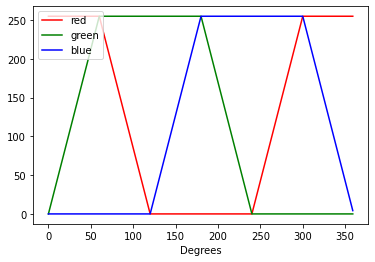

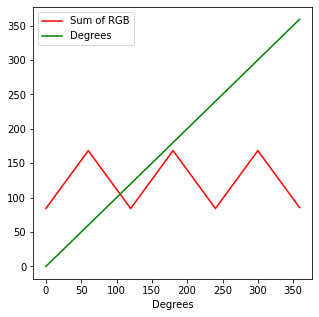

In [62]:
plt.plot([i for i in range(360)], [i[0] for i in degrees], color = "red", label = "red")
plt.plot([i for i in range(360)], [i[1] for i in degrees], color = "green", label = "green")
plt.plot([i for i in range(360)], [i[2] for i in degrees], color = "blue", label = "blue")
plt.xlabel("Degrees")
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(5, 5))
plt.plot([i for i in range(360)], [i[3] for i in degrees], color = "red", label = "Sum of RGB")
plt.plot([i for i in range(360)], [i for i in range(360)], color = "green", label = "Degrees")
plt.xlabel("Degrees")
plt.legend(loc='upper left')
plt.show()

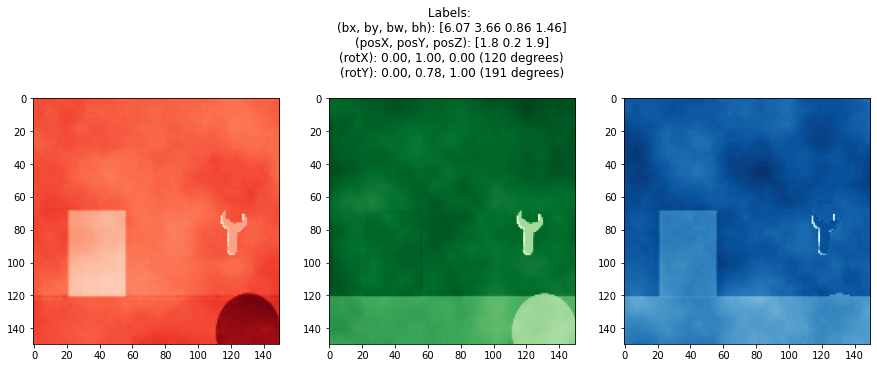

In [77]:
random_index = random.randrange(IMAGES)
fig, axs = plt.subplots(ncols = 3, figsize = (15, 15))

axs[0].imshow(X[random_index][:, :, 0], cmap="Reds")
axs[1].imshow(X[random_index][:, :, 1], cmap="Greens")
axs[2].imshow(X[random_index][:, :, 2], cmap="Blues")

title = "Labels: \n\
(bx, by, bw, bh): {frameLabels}\n\
(posX, posY, posZ): {positionLabels}\n\
(rotX): {rx:.2f}, {gx:.2f}, {bx:.2f} ({xDegrees1} degrees)\n\
(rotY): {ry:.2f}, {gy:.2f}, {by:.2f} ({yDegrees1} degrees)\n".format(frameLabels = y[random_index][:4],
                              positionLabels = y[random_index][4:7],
                              rx = y[random_index][7],
                              gx = y[random_index][8],
                              bx =y[random_index][9],
                              ry = y[random_index][10],
                              gy = y[random_index][11],
                              by = y[random_index][12],
                              xDegrees1 = int(RGBToAngle(y[random_index][7:10])),
                              yDegrees1 = int(RGBToAngle(y[random_index][10:13])))

axs[1].set_title(title)

plt.show()

# Model

### Custom accuracy metric

In [78]:
from tensorflow.math import add, subtract, multiply, divide, sqrt, atan2

def position_error_x(y_true, y_pred):
    error_sum = 0
    samples = len(y_true)
    for i in range(samples):
        error_sum += abs(y_true[i][0] - y_pred[i][0])
    return (error_sum * 10)/samples

def position_error_y(y_true, y_pred):
    error_sum = 0
    for i in range(len(y_true)):
        error_sum += abs(y_true[i][1] - y_pred[i][1])
    return (error_sum * 10)/len(y_true)

def position_error_z(y_true, y_pred):
    error_sum = 0
    for i in range(len(y_true)):
        error_sum += abs(y_true[i][2] - y_pred[i][2])
    return (error_sum * 10)/len(y_true)

def acc_20(y_true, y_pred):
    count = 0
    for i in range(len(y_true)):
        angle_true = RGBToAngle(y_true[i])
        angle_pred = RGBToAngle(y_pred[i])
        
        if(abs(angle_true - angle_pred) < 20):
            count += 1
    return count / len(y_true)

def acc_15(y_true, y_pred):
    count = 0
    for i in range(len(y_true)):
        angle_true = RGBToAngle(y_true[i])
        angle_pred = RGBToAngle(y_pred[i])
        
        if(abs(angle_true - angle_pred) < 15):
            count += 1
    return count / len(y_true)

def acc_10(y_true, y_pred):
    count = 0
    for i in range(len(y_true)):
        angle_true = RGBToAngle(y_true[i])
        angle_pred = RGBToAngle(y_pred[i])
        
        if(abs(angle_true - angle_pred) < 10):
            count += 1
    return count / len(y_true)

def acc_5(y_true, y_pred):
    count = 0
    for i in range(len(y_true)):
        angle_true = RGBToAngle(y_true[i])
        angle_pred = RGBToAngle(y_pred[i])
        
        if(abs(angle_true - angle_pred) < 5):
            count += 1
    return count / len(y_true)

def IoU(y_true, y_pred):
    mean = 0
    for i in range (len(y_true)):
        x1, y1, w1, h1 = y_true[i]
        x2, y2, w2, h2 = y_pred[i]
        
        w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
        h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
        
        if w_I <= 0 or h_I <= 0:  # no overlap
            continue
        else:
            I = w_I * h_I
            U = w1 * h1 + w2 * h2 - I
            mean += I / U
            
    mean /= len(y_true)
    return mean 

Model: "Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
ps_conv_0 (Conv2D)              (None, 148, 148, 16) 448         Inputs[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_28 (LeakyReLU)      (None, 148, 148, 16) 0           ps_conv_0[0][0]                  
__________________________________________________________________________________________________
ps_conv_1 (Conv2D)              (None, 146, 146, 32) 4640        leaky_re_lu_28[0][0]             
______________________________________________________________________________________________

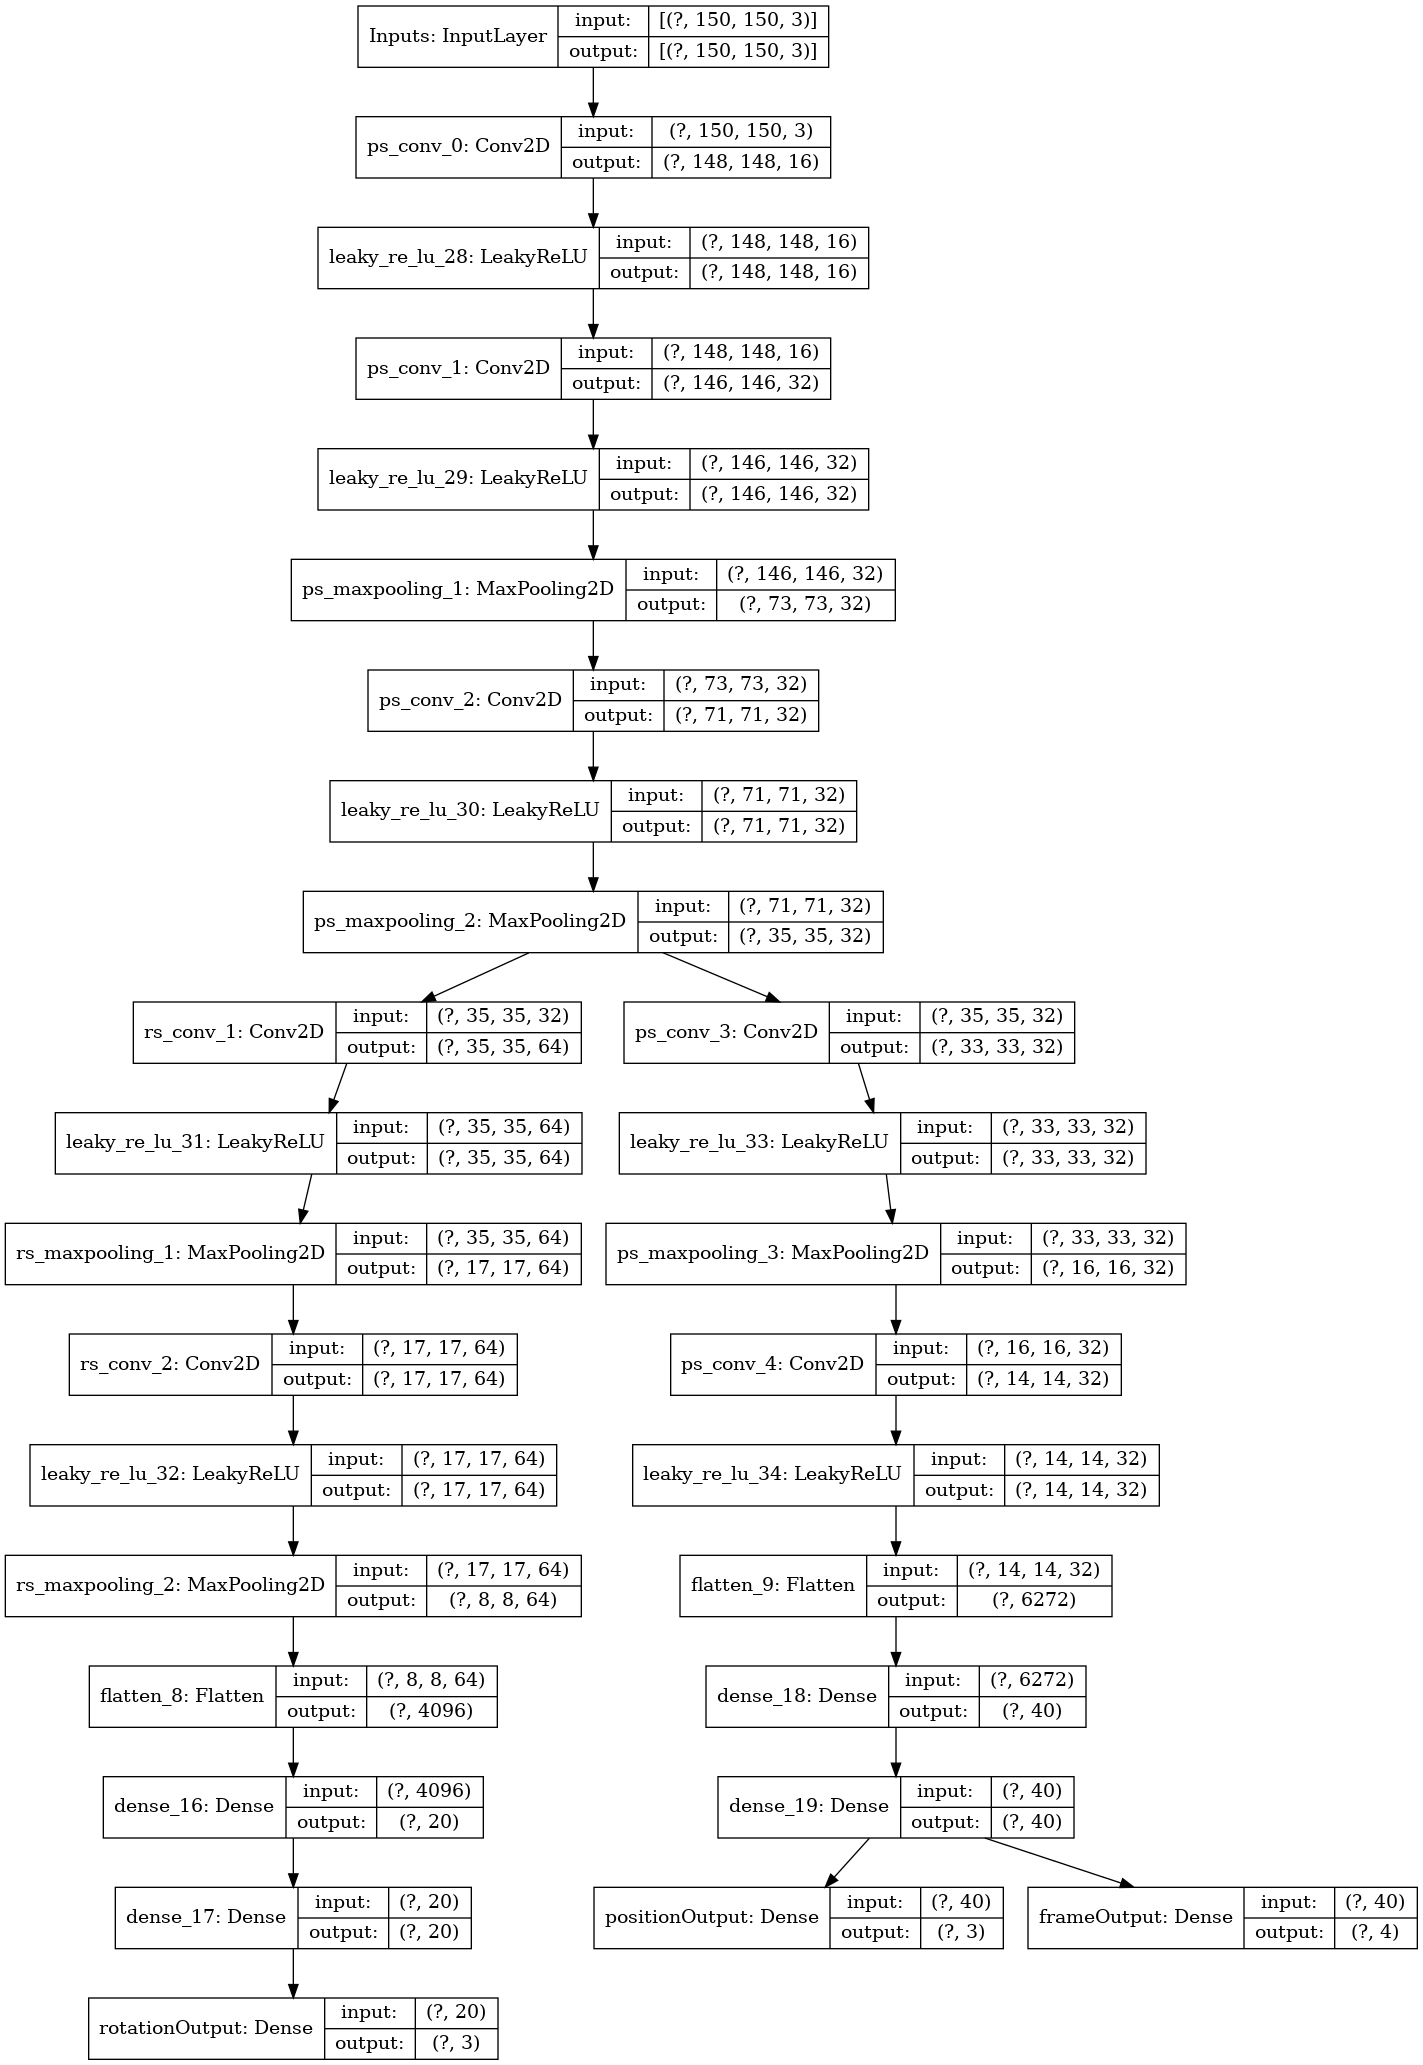

In [79]:
inputs = Input(name = "Inputs",
              shape = (IMG_SIZE, IMG_SIZE, 3))

# Main Stream
positionStream = Conv2D(name = "ps_conv_0",
                   filters = 16,
                   kernel_size = 3,
                   strides = 1,
                   padding = "valid",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(inputs)

positionStream = LeakyReLU()(positionStream)

positionStream = Conv2D(name = "ps_conv_1",
                   filters = 32,
                   kernel_size = 3,
                   strides = 1,
                   padding = "valid",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(positionStream)

positionStream = LeakyReLU()(positionStream)

positionStream = MaxPooling2D(name="ps_maxpooling_1", 
                          pool_size = (2, 2), 
                          strides = 2)(positionStream)

positionStream = Conv2D(name = "ps_conv_2",
                   filters = 32,
                   kernel_size = 3,
                   strides = 1,
                   padding = "valid",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(positionStream)

positionStream = LeakyReLU()(positionStream)

positionStream = MaxPooling2D(name="ps_maxpooling_2", 
                          pool_size = (2, 2), 
                          strides = 2)(positionStream)

# ROTATION START

rotationStream = Conv2D(name = "rs_conv_1",
                   filters = 64,
                   kernel_size = 3,
                   strides = 1,
                   padding = "same",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(positionStream)

rotationStream = LeakyReLU()(rotationStream)

rotationStream = MaxPooling2D(name="rs_maxpooling_1", 
                          pool_size = (2, 2), 
                          strides = 2)(rotationStream)

rotationStream = Conv2D(name = "rs_conv_2",
                   filters = 64,
                   kernel_size = 3,
                   strides = 1,
                   padding = "same",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(rotationStream)

rotationStream = LeakyReLU()(rotationStream)

rotationStream = MaxPooling2D(name="rs_maxpooling_2", 
                          pool_size = (2, 2), 
                          strides = 2)(rotationStream)

rotationStream = Flatten()(rotationStream)

rotationStream = Dense(20, activation = "relu")(rotationStream)
rotationStream = Dense(20, activation = "relu")(rotationStream)

rotationStream = Dense(3, name = "rotationOutput")(rotationStream)

# ROTATION END

positionStream = Conv2D(name = "ps_conv_3",
                   filters = 32,
                   kernel_size = 3,
                   strides = 1,
                   padding = "valid",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(positionStream)

positionStream = LeakyReLU()(positionStream)

positionStream = MaxPooling2D(name="ps_maxpooling_3", 
                          pool_size = (2, 2), 
                          strides = 2)(positionStream)

positionStream = Conv2D(name = "ps_conv_4",
                   filters = 32,
                   kernel_size = 3,
                   strides = 1,
                   padding = "valid",
                   kernel_initializer=tf.keras.initializers.GlorotUniform())(positionStream)

positionStream = LeakyReLU()(positionStream)

positionStream = Flatten()(positionStream)

positionStream = Dense(40, activation = "relu")(positionStream)
positionStream = Dense(40, activation = "relu")(positionStream)

positionStreamOutput = Dense(3, name = "positionOutput")(positionStream)
frameStreamOutput = Dense(4, name = "frameOutput")(positionStream)

adadelta_optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95)

model = keras.Model(inputs,[positionStreamOutput, rotationStream, frameStreamOutput], name = "Model")
model.compile(optimizer = adadelta_optimizer,
             loss = {"positionOutput": tf.keras.losses.MeanSquaredError(), 
                     "rotationOutput": tf.keras.losses.MeanSquaredError(), 
                     "frameOutput": tf.keras.losses.MeanSquaredError()},

             metrics = {"positionOutput": [position_error_x, 
                                           position_error_y, 
                                           position_error_z], 
                        "rotationOutput": [acc_20, 
                                           acc_15, 
                                           acc_10, 
                                           acc_5],
                        "frameOutput": [IoU]},
             run_eagerly=True)

model.summary()
keras.utils.plot_model(model, "model.png", show_shapes=True)

# Training

In [80]:
training_data_x = X[:int(IMAGES*0.8)]
training_data_y = y[:int(IMAGES*0.8)]
validation_data_x = X[int(IMAGES*0.8):IMAGES]
validation_data_y = y[int(IMAGES*0.8):IMAGES]

history = model.fit(x = training_data_x,
                    y = {"positionOutput": training_data_y[:, 4:7], "rotationOutput": training_data_y[:, 10:13], "frameOutput": training_data_y[:, 0:4]},
                    validation_data = (validation_data_x, {"positionOutput": validation_data_y[:, 4:7], "rotationOutput": validation_data_y[:, 10:13], "frameOutput": validation_data_y[:, 0:4]}),
                    batch_size = 32,
                    epochs = 12)

Epoch 1/12
 24/125 [====>.........................] - ETA: 1:40 - loss: 11.4048 - positionOutput_loss: 2.8964 - rotationOutput_loss: 0.4382 - frameOutput_loss: 8.0701 - positionOutput_position_error_x: 11.2659 - positionOutput_position_error_y: 10.4079 - positionOutput_position_error_z: 19.6156 - rotationOutput_acc_20: 0.1094 - rotationOutput_acc_15: 0.0872 - rotationOutput_acc_10: 0.0560 - rotationOutput_acc_5: 0.0273 - frameOutput_IoU: 0.0000e+00

KeyboardInterrupt: 

loss
positionOutput_loss
rotationOutput_loss
frameOutput_loss
positionOutput_position_error_x
positionOutput_position_error_y
positionOutput_position_error_z
rotationOutput_acc_20
rotationOutput_acc_15
rotationOutput_acc_10
rotationOutput_acc_5
frameOutput_IoU
val_loss
val_positionOutput_loss
val_rotationOutput_loss
val_frameOutput_loss
val_positionOutput_position_error_x
val_positionOutput_position_error_y
val_positionOutput_position_error_z
val_rotationOutput_acc_20
val_rotationOutput_acc_15
val_rotationOutput_acc_10
val_rotationOutput_acc_5
val_frameOutput_IoU


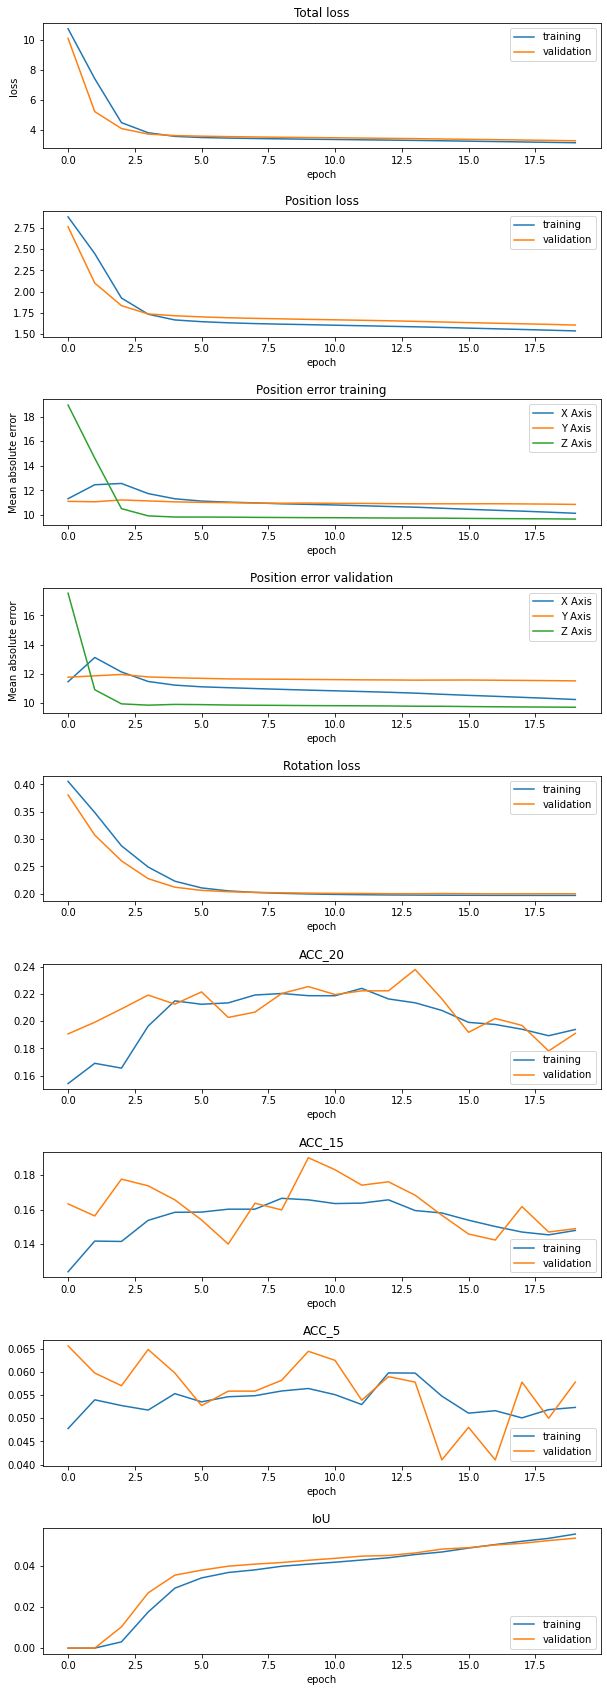

In [16]:
for k in history.history.keys():
    print(k)

# optimizers_names = ["sgd", "adam", "adadelta", "rmsprop"]
# for name, history in zip(optimizers_names, histories):
#     fig, axs = plt.subplots(ncols = 1, nrows = 9, figsize=(10,30))
#     fig.suptitle(name)

#     axs[0].plot(history.history['loss'], label = "training")
#     axs[0].plot(history.history['val_loss'], label = "validation")
#     axs[0].set_ylabel('loss')
#     axs[0].set_xlabel('epoch')
#     axs[0].legend(loc='upper right')
#     axs[0].set_title("Total loss")

#     axs[1].plot(history.history['positionOutput_loss'], label = "training")
#     axs[1].plot(history.history['val_positionOutput_loss'], label = "validation")
#     axs[1].set_xlabel('epoch')
#     axs[1].legend(loc='upper right')
#     axs[1].set_title("Position loss")

#     axs[2].plot(history.history['positionOutput_position_error_x'], label = "X Axis")
#     axs[2].plot(history.history['positionOutput_position_error_y'], label = "Y Axis")
#     axs[2].plot(history.history['positionOutput_position_error_z'], label = "Z Axis")
#     axs[2].set_ylabel('Mean absolute error')
#     axs[2].set_xlabel('epoch')
#     axs[2].legend(loc='upper right')
#     axs[2].set_title("Position error training")

#     axs[3].plot(history.history['val_positionOutput_position_error_x'], label = "X Axis")
#     axs[3].plot(history.history['val_positionOutput_position_error_y'], label = "Y Axis")
#     axs[3].plot(history.history['val_positionOutput_position_error_z'], label = "Z Axis")
#     axs[3].set_ylabel('Mean absolute error')
#     axs[3].set_xlabel('epoch')
#     axs[3].legend(loc='upper right')
#     axs[3].set_title("Position error validation")

#     axs[4].plot(history.history['rotationOutput_loss'], label = "training")
#     axs[4].plot(history.history['val_rotationOutput_loss'], label = "validation")
#     axs[4].set_xlabel('epoch')
#     axs[4].legend(loc='upper right')
#     axs[4].set_title("Rotation loss")

#     axs[5].plot(history.history['rotationOutput_acc_20'], label = "training")
#     axs[5].plot(history.history['val_rotationOutput_acc_20'], label = "validation")
#     axs[5].set_xlabel('epoch')
#     axs[5].legend(loc='lower right')
#     axs[5].set_title("ACC_20")

#     axs[6].plot(history.history['rotationOutput_acc_15'], label = "training")
#     axs[6].plot(history.history['val_rotationOutput_acc_15'], label = "validation")
#     axs[6].set_xlabel('epoch')
#     axs[6].legend(loc='lower right')
#     axs[6].set_title("ACC_15")

#     axs[7].plot(history.history['rotationOutput_acc_5'], label = "training")
#     axs[7].plot(history.history['val_rotationOutput_acc_5'], label = "validation")
#     axs[7].set_xlabel('epoch')
#     axs[7].legend(loc='lower right')
#     axs[7].set_title("ACC_5")

#     axs[8].plot(history.history['frameOutput_IoU'], label = "training")
#     axs[8].plot(history.history['val_frameOutput_IoU'], label = "validation")
#     axs[8].set_xlabel('epoch')
#     axs[8].legend(loc='lower right')
#     axs[8].set_title("IoU")

#     plt.subplots_adjust(hspace=0.5)
#     plt.show()

# optimizers_names = ["sgd", "adam", "adadelta", "rmsprop"]
# for name, history in zip(optimizers_names, histories):
#     fig, axs = plt.subplots(ncols = 1, nrows = 9, figsize=(10,30))
#     fig.suptitle(name)

#     axs[0].plot(history.history['loss'], label = "training")
#     axs[0].plot(history.history['val_loss'], label = "validation")
#     axs[0].set_ylabel('loss')
#     axs[0].set_xlabel('epoch')
#     axs[0].legend(loc='upper right')
#     axs[0].set_title("Total loss")
#     axs[0].set_yscale('log')

#     axs[1].plot(history.history['positionOutput_loss'], label = "training")
#     axs[1].plot(history.history['val_positionOutput_loss'], label = "validation")
#     axs[1].set_xlabel('epoch')
#     axs[1].legend(loc='upper right')
#     axs[1].set_title("Position loss")
#     axs[1].set_yscale('log')

#     axs[2].plot(history.history['positionOutput_position_error_x'], label = "X Axis")
#     axs[2].plot(history.history['positionOutput_position_error_y'], label = "Y Axis")
#     axs[2].plot(history.history['positionOutput_position_error_z'], label = "Z Axis")
#     axs[2].set_ylabel('Mean absolute error')
#     axs[2].set_xlabel('epoch')
#     axs[2].legend(loc='upper right')
#     axs[2].set_title("Position error training")
#     axs[2].set_yscale('log')

#     axs[3].plot(history.history['val_positionOutput_position_error_x'], label = "X Axis")
#     axs[3].plot(history.history['val_positionOutput_position_error_y'], label = "Y Axis")
#     axs[3].plot(history.history['val_positionOutput_position_error_z'], label = "Z Axis")
#     axs[3].set_ylabel('Mean absolute error')
#     axs[3].set_xlabel('epoch')
#     axs[3].legend(loc='upper right')
#     axs[3].set_title("Position error validation")
#     axs[3].set_yscale('log')

#     axs[4].plot(history.history['rotationOutput_loss'], label = "training")
#     axs[4].plot(history.history['val_rotationOutput_loss'], label = "validation")
#     axs[4].set_xlabel('epoch')
#     axs[4].legend(loc='upper right')
#     axs[4].set_title("Rotation loss")
#     axs[4].set_yscale('log')

#     axs[5].plot(history.history['rotationOutput_acc_20'], label = "training")
#     axs[5].plot(history.history['val_rotationOutput_acc_20'], label = "validation")
#     axs[5].set_xlabel('epoch')
#     axs[5].legend(loc='lower right')
#     axs[5].set_title("ACC_20")
#     axs[5].set_yscale('log')

#     axs[6].plot(history.history['rotationOutput_acc_15'], label = "training")
#     axs[6].plot(history.history['val_rotationOutput_acc_15'], label = "validation")
#     axs[6].set_xlabel('epoch')
#     axs[6].legend(loc='lower right')
#     axs[6].set_title("ACC_15")
#     axs[6].set_yscale('log')

#     axs[7].plot(history.history['rotationOutput_acc_5'], label = "training")
#     axs[7].plot(history.history['val_rotationOutput_acc_5'], label = "validation")
#     axs[7].set_xlabel('epoch')
#     axs[7].legend(loc='lower right')
#     axs[7].set_title("ACC_5")
#     axs[7].set_yscale('log')
    
#     axs[8].plot(history.history['frameOutput_IoU'], label = "training")
#     axs[8].plot(history.history['val_frameOutput_IoU'], label = "validation")
#     axs[8].set_xlabel('epoch')
#     axs[8].legend(loc='lower right')
#     axs[8].set_title("IoU")
#     axs[8].set_yscale('log')

#     plt.subplots_adjust(hspace=0.5)
#     plt.show()

# history = histories[2]

fig, axs = plt.subplots(ncols = 1, nrows = 9, figsize=(10,30))

axs[0].plot(history.history['loss'], label = "training")
axs[0].plot(history.history['val_loss'], label = "validation")
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(loc='upper right')
axs[0].set_title("Total loss")

axs[1].plot(history.history['positionOutput_loss'], label = "training")
axs[1].plot(history.history['val_positionOutput_loss'], label = "validation")
axs[1].set_xlabel('epoch')
axs[1].legend(loc='upper right')
axs[1].set_title("Position loss")

axs[2].plot(history.history['positionOutput_position_error_x'], label = "X Axis")
axs[2].plot(history.history['positionOutput_position_error_y'], label = "Y Axis")
axs[2].plot(history.history['positionOutput_position_error_z'], label = "Z Axis")
axs[2].set_ylabel('Mean absolute error')
axs[2].set_xlabel('epoch')
axs[2].legend(loc='upper right')
axs[2].set_title("Position error training")

axs[3].plot(history.history['val_positionOutput_position_error_x'], label = "X Axis")
axs[3].plot(history.history['val_positionOutput_position_error_y'], label = "Y Axis")
axs[3].plot(history.history['val_positionOutput_position_error_z'], label = "Z Axis")
axs[3].set_ylabel('Mean absolute error')
axs[3].set_xlabel('epoch')
axs[3].legend(loc='upper right')
axs[3].set_title("Position error validation")

axs[4].plot(history.history['rotationOutput_loss'], label = "training")
axs[4].plot(history.history['val_rotationOutput_loss'], label = "validation")
axs[4].set_xlabel('epoch')
axs[4].legend(loc='upper right')
axs[4].set_title("Rotation loss")

axs[5].plot(history.history['rotationOutput_acc_20'], label = "training")
axs[5].plot(history.history['val_rotationOutput_acc_20'], label = "validation")
axs[5].set_xlabel('epoch')
axs[5].legend(loc='lower right')
axs[5].set_title("ACC_20")

axs[6].plot(history.history['rotationOutput_acc_15'], label = "training")
axs[6].plot(history.history['val_rotationOutput_acc_15'], label = "validation")
axs[6].set_xlabel('epoch')
axs[6].legend(loc='lower right')
axs[6].set_title("ACC_15")

axs[7].plot(history.history['rotationOutput_acc_5'], label = "training")
axs[7].plot(history.history['val_rotationOutput_acc_5'], label = "validation")
axs[7].set_xlabel('epoch')
axs[7].legend(loc='lower right')
axs[7].set_title("ACC_5")

axs[8].plot(history.history['frameOutput_IoU'], label = "training")
axs[8].plot(history.history['val_frameOutput_IoU'], label = "validation")
axs[8].set_xlabel('epoch')
axs[8].legend(loc='lower right')
axs[8].set_title("IoU")

plt.subplots_adjust(hspace=0.5)
plt.show()

# plt.figure(figsize=(8,5))
# plt.plot(histories[0].history["val_loss"], label = "sgd")
# plt.plot(histories[1].history["val_loss"], label = "adam")
# plt.plot(histories[2].history["val_loss"], label = "adadelta")
# plt.plot(histories[3].history["val_loss"], label = "rsmprop")
# plt.xlabel("Epochs")
# # plt.ylabel("Validation loss")
# plt.title("Validation loss")
# plt.legend(loc="upper right")
# plt.yscale('log')

# plt.show()

# plt.figure(figsize=(8,5))
# plt.plot(histories[0].history["val_rotationOutput_acc_5"], label = "sgd")
# plt.plot(histories[1].history["val_rotationOutput_acc_5"], label = "adam")
# plt.plot(histories[2].history["val_rotationOutput_acc_5"], label = "adadelta")
# plt.plot(histories[3].history["val_rotationOutput_acc_5"], label = "rsmprop")
# plt.xlabel("Epochs")
# # plt.ylabel("Validation loss")
# plt.title("Validation ACC_5")
# plt.legend(loc="upper left")
# # plt.yscale('log')

# plt.show()

# plt.figure(figsize=(8,5))
# plt.plot(histories[0].history["val_rotationOutput_loss"], label = "sgd")
# plt.plot(histories[1].history["val_rotationOutput_loss"], label = "adam")
# plt.plot(histories[2].history["val_rotationOutput_loss"], label = "adadelta")
# plt.plot(histories[3].history["val_rotationOutput_loss"], label = "rsmprop")
# plt.xlabel("Epochs")
# plt.ylabel("Validation loss")
# plt.title("Rotation loss")
# plt.legend(loc="center right")
# plt.yscale('log')

plt.show()


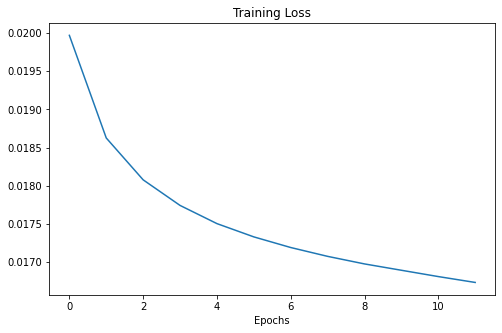

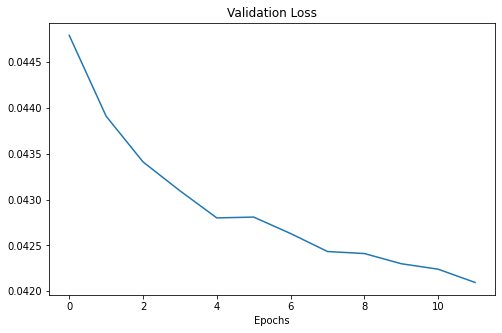

In [95]:
plt.figure(figsize=(8,5))
# plt.plot(histories[2].history["val_loss"], label = "validation")
plt.plot(histories[2].history["loss"], label = "training")
plt.xlabel("Epochs")
# plt.ylabel("Validation loss")
plt.title("Training Loss")
# plt.legend(loc="upper right")
# plt.yscale('log')

plt.show()

plt.figure(figsize=(8,5))
plt.plot(histories[2].history["val_loss"], label = "validation")
# plt.plot(histories[2].history["loss"], label = "training")
plt.xlabel("Epochs")
# plt.ylabel("Validation loss")
plt.title("Validation Loss")
# plt.legend(loc="upper right")
# plt.yscale('log')

plt.show()

# Results

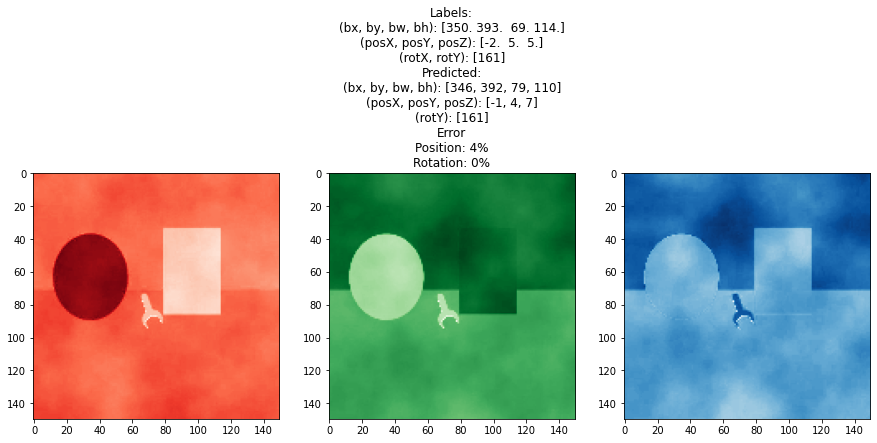

In [56]:
# random_index = random.randrange(len(training_data))
# Images from trainig set
# random_index = random.randrange(IMAGES*0.8)

# Images from validation set
random_index = random.randrange(IMAGES*0.9 ,IMAGES)

prediction = model.predict(X[random_index].reshape(1, IMG_SIZE, IMG_SIZE, 3))

fig, axs = plt.subplots(ncols = 3, figsize = (15, 15))

axs[0].imshow(X[random_index][:, :, 0], cmap="Reds")
axs[1].imshow(X[random_index][:, :, 1], cmap="Greens")
axs[2].imshow(X[random_index][:, :, 2], cmap="Blues")

frame_og = y[random_index][:4]*100
pos_og = y[random_index][4:7]*10
rot_og = [int(RGBToAngle(y[random_index][10:13]))]

frame_pred = [int(p*100) for p in prediction[2][0]]
pos_pred = [int(p*10) for p in prediction[0][0]]
rot_pred = [int(RGBToAngle(prediction[1][0][0:3]))]

pos_error = int(sum((abs(pos_pred-pos_og)/30)*100)/3)
rot_error = int(abs((rot_pred[0]-rot_og[0])/360)*100)

axs[1].set_title(f"Labels:\
\n(bx, by, bw, bh): {frame_og}\
\n(posX, posY, posZ): {pos_og}\
\n(rotX, rotY): {rot_og}\n\
Predicted:\
\n(bx, by, bw, bh): {frame_pred}\
\n(posX, posY, posZ): {pos_pred}\
\n(rotY): {rot_pred}\
\nError\
\nPosition: {pos_error}%\
\nRotation: {rot_error}%")

plt.show()

# Layer output extraction

In [57]:
def extract_layer_data(layer):
    submodel = keras.Model(inputs = model.input, outputs = layer.output)
    submodel_output = submodel.predict(np.array(X[random_index]).reshape(1, IMG_SIZE, IMG_SIZE, 3))
    output_shape = submodel_output.shape
    
    graph_size = 10
    
    index = 0
    if (len(output_shape) != 2):
        if(output_shape[-1]>=4):
            fig, axs = plt.subplots(4, int(output_shape[-1]/4), figsize=(graph_size, graph_size))
            fig.suptitle(f"{layer.name}, [{output_shape}]")
            for col in range(0, 4):
                for row in range(0, int(output_shape[-1]/4)):
                    axs[col, row].imshow(submodel_output[0, :, :, index], cmap="Greys")
                    index += 1
                    axs[col, row].axis('off')
            
        else:
            fig, axs = plt.subplots(ncols = output_shape[-1], figsize=(graph_size, graph_size))
            for col in range(0, output_shape[-1]):
                axs[col].imshow(submodel_output[0, :, :, index], cmap="Greys")
                if(int(output_shape[-1]/2) == col):
                    axs[col].set_title(f"{layer.name}, [{output_shape}]")
                index += 1
                axs[col].axis('off')
    plt.tight_layout()
    
# for layer in model.layers:
#     extract_layer_data(layer)

In [144]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")

In [90]:
plt.rcParams.update({'font.size': 10})